In [1]:
%pip install python-binance

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from binance.client import Client
import numpy as np
import matplotlib.pyplot as plt


In [3]:
# Initialize the Binance client
api_key = 'your_api_key'
api_secret = 'your_api_secret'
client = Client(api_key, api_secret)

# Get historical data for BTCUSDT
klines = client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_1DAY, "1 Jan, 2010", "28 Feb, 2025")

# Create a DataFrame
df = pd.DataFrame(klines, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

# Set timestamp as index
df.set_index('timestamp', inplace=True)

btc = df[['close']].copy()
print(btc.head())

                    close
timestamp                
2017-08-17  4285.08000000
2017-08-18  4108.37000000
2017-08-19  4139.98000000
2017-08-20  4086.29000000
2017-08-21  4016.00000000


In [4]:
def calculate_rsi(data, window):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Calculate RSI for the btc DataFrame
btc['close'] = btc['close'].astype(float)
btc['rsi'] = calculate_rsi(btc['close'], window=14)
print(btc.head(20))

              close        rsi
timestamp                     
2017-08-17  4285.08        NaN
2017-08-18  4108.37        NaN
2017-08-19  4139.98        NaN
2017-08-20  4086.29        NaN
2017-08-21  4016.00        NaN
2017-08-22  4040.00        NaN
2017-08-23  4114.01        NaN
2017-08-24  4316.01        NaN
2017-08-25  4280.68        NaN
2017-08-26  4337.44        NaN
2017-08-27  4310.01        NaN
2017-08-28  4386.69        NaN
2017-08-29  4587.48        NaN
2017-08-30  4555.14  62.719001
2017-08-31  4724.89  67.858274
2017-09-01  4834.91  81.190006
2017-09-02  4472.14  61.102643
2017-09-03  4509.08  64.292040
2017-09-04  4100.11  52.313524
2017-09-05  4366.47  57.923452


In [46]:
def portfolio(rsi_up = 50, rsi_down = 50, hand = 10):
    btc['signal'] = np.where(btc['rsi'] < rsi_down, 1, np.where(btc['rsi'] > rsi_up, -1, 0))

    btc['position'] = hand / btc['close'] * btc['signal']

    btc['total_position'] = 0
    for i in range(1, len(btc)):
        btc['total_position'].iloc[i] = btc['position'].iloc[i] + btc['total_position'].iloc[i-1]

    btc['cost'] = np.where(btc['signal'] == -1, -btc['close'] * btc['position'], np.where(btc['signal'] == 1, -btc['close'] * btc['position'], 0))

    btc['total_cost'] = 0.0

    for i in range(1, len(btc)):
        btc['total_cost'].iloc[i] = btc['cost'].iloc[i] + btc['total_cost'].iloc[i-1]

    btc['pnl'] = btc['total_cost'] + (btc['total_position'] * btc['close'])
    btc.to_csv('btc.csv')
    
    return btc['pnl'][-1]

In [ ]:
result = []
for _ in range(10, 100, 10):
    result.append(portfolio(rsi_up = _, rsi_down = 100 - _, hand = 10))
plt.plot(range(10, 100, 10), result)

C:\Users\isaac\AppData\Local\Temp\ipykernel_1740\1459268791.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  btc['total_position'].iloc[i] = btc['position'].iloc[i] + btc['total_position'].iloc[i-1]
C:\Users\isaac\AppData\Local\Temp\ipyke

-8313.526691493182


C:\Users\isaac\AppData\Local\Temp\ipykernel_1740\1459268791.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return btc['pnl'][-1]


In [42]:
result = btc['pnl']
btc_price = btc['close']
btc_price_percent= btc_price.pct_change().dropna()
#result = result.pct_change().dropna()
#result = result.iloc[1:]
#btc_price = btc_price.iloc[1:]
btc_price_percent

timestamp
2017-08-18   -0.041238
2017-08-19    0.007694
2017-08-20   -0.012969
2017-08-21   -0.017201
2017-08-22    0.005976
                ...   
2025-02-24   -0.048880
2025-02-25   -0.031375
2025-02-26   -0.049958
2025-02-27    0.005442
2025-02-28   -0.004234
Name: close, Length: 2752, dtype: float64

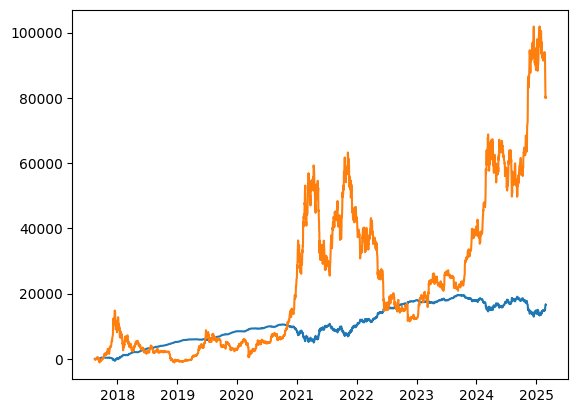

Correlation:  0.500843438498194
Covariance:  69761721.32445265
Expected return of portfolio:  -inf Mean of BTC:  0.001777403125045818
Standard Deviation of portfolio:  5776.096505061018 Standard Deviation of BTC:  24114.638665384362
Sharpe Ratio of portfolio:  1.8163741709532568 Sharpe Ratio of BTC:  1.1836621298111714


In [ ]:
plt.plot(btc['pnl'])
plt.plot(btc['close'] - btc['close'].iloc[0])
plt.show()

print("Correlation: ", result.corr(btc_price))
print("Covariance: ", result.cov(btc_price))
print("Expected return of portfolio: ", result.pct_change().mean(), "Mean of BTC: ", btc_price.pct_change().mean())
print("Standard Deviation of portfolio: ", result.std(), "Standard Deviation of BTC: ", btc_price.std())
print("Sharpe Ratio of portfolio: ", result.mean() / result.std(), "Sharpe Ratio of BTC: ", btc_price.mean() / btc_price.std())


